<a href="https://colab.research.google.com/github/LHMade/LH-Made-Cookies/blob/main/sori_LH_Made_Cookies_finfin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
# 한글 폰트
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [13]:
from google.colab import files
uploaded = files.upload()

Saving 10.성남시_지하철역.csv to 10.성남시_지하철역.csv


In [68]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
from geopy.distance import geodesic as distance
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

plt.rc('font', family='NanumBarunGothic')

In [65]:
# 데이터 파일 경로 설정
data_files = {
    "거주인구": "/content/1.성남시_거주인구.csv",
    "상권정보": "/content/2.성남시_상권정보.csv",
    "상가개폐업": "/content/3.성남시_상가개폐업.csv",
    "표제부": "/content/4.성남시_표제부.csv",
    "층별개요": "/content/5.성남시_층별개요.csv",
    "지식산업센터": "/content/7.성남시_지식산업센터.csv",
    "개별공시지가": "/content/8.성남시_개별공시지가.csv",
    "버스정류장": "/content/9.성남시_버스정류장.csv",
    "지하철역": "/content/10.성남시_지하철역.csv",
}

In [3]:
# 데이터 불러오기
data = {}
for key, path in data_files.items():
    try:
        data[key] = pd.read_csv(path)
    except Exception as e:
        print(f"{key} 데이터 로드 실패: {e}")

<ipython-input-3-a121223c6768>:5: DtypeWarning: Columns (14,15,34,58,59,60,61,67) have mixed types. Specify dtype option on import or set low_memory=False.
  data[key] = pd.read_csv(path)
<ipython-input-3-a121223c6768>:5: DtypeWarning: Columns (10,11,25) have mixed types. Specify dtype option on import or set low_memory=False.
  data[key] = pd.read_csv(path)


# **데이터 전처리**

In [69]:
# 지식산업센터 데이터 전처리
df_center = data["지식산업센터"].copy()
df_center = df_center[['klg_ids_ct_nm', 'lat', 'lon', 'tot_cpn', 'cpn_in_2406']].rename(
    columns={'klg_ids_ct_nm': '센터명', 'lat': '위도', 'lon': '경도', 'tot_cpn': '총기업수', 'cpn_in_2406': '입주기업수_2024'}
)
df_center['공실률'] = 1 - (df_center['입주기업수_2024'] / df_center['총기업수'])
df_center['공실률'] = df_center['공실률'].fillna(0)

In [72]:
# 좌표를 WGS84 좌표계(EPSG:4326)로 변환
df_center = gpd.GeoDataFrame(df_center, geometry=gpd.points_from_xy(df_center['경도'], df_center['위도']), crs='EPSG:4326')

df_transport = data["버스정류장"].copy()
df_transport = gpd.GeoDataFrame(df_transport, geometry=gpd.points_from_xy(df_transport['lon'], df_transport['lat']), crs='EPSG:4326')

# **가설 1: 대중교통 접근성과 공실률 분석**

In [73]:
# 가설 1: 대중교통 접근성과 공실률 분석 (최단거리 계산)
df_center_transport = df_center.copy()
df_center_transport['최단거리_버스정류장'] = df_center_transport.geometry.apply(
    lambda center: df_transport.distance(center).min()
)

<ipython-input-73-fee45b744136>:4: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lambda center: df_transport.distance(center).min()


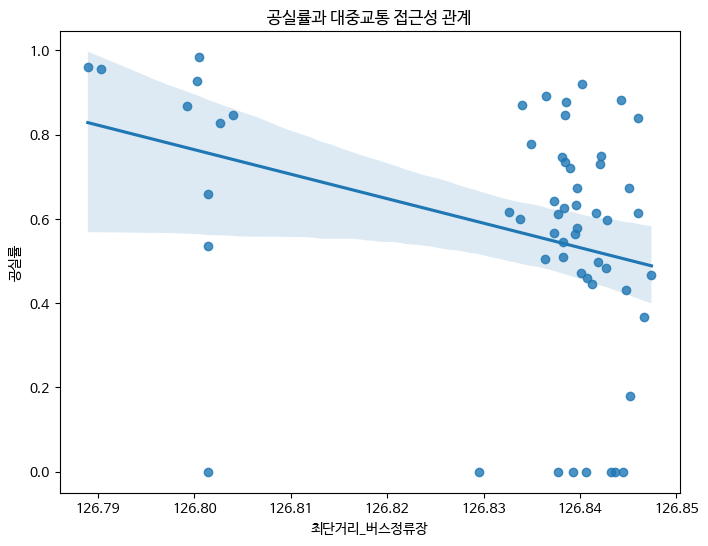

/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


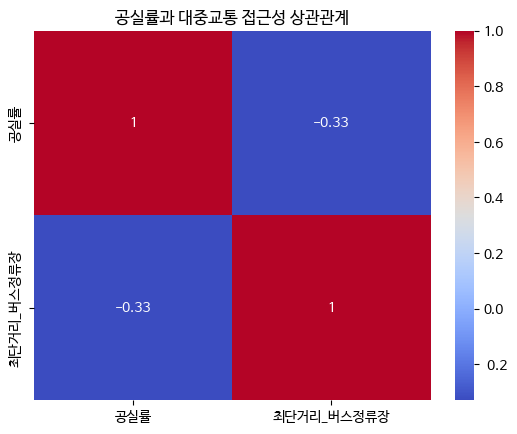

In [74]:
# 상관관계 분석 및 시각화
plt.figure(figsize=(8, 6))
sns.regplot(x=df_center_transport['최단거리_버스정류장'], y=df_center_transport['공실률'])
plt.title("공실률과 대중교통 접근성 관계")
plt.xlabel("최단거리_버스정류장")
plt.ylabel("공실률")
plt.show()

correlation_1 = df_center_transport[['공실률', '최단거리_버스정류장']].corr()
sns.heatmap(correlation_1, annot=True, cmap="coolwarm")
plt.title("공실률과 대중교통 접근성 상관관계")
plt.show()

In [75]:
# 머신러닝 모델 학습
X = df_center_transport[['최단거리_버스정류장']].dropna()
y = df_center_transport.loc[X.index, '공실률']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("Linear Regression R² Score (대중교통):", r2_score(y_test, y_pred_lr))

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest R² Score (대중교통):", r2_score(y_test, y_pred_rf))

Linear Regression R² Score (대중교통): 0.06728829609214582
Random Forest R² Score (대중교통): -0.7820652290326862


# **가설 2: 상권 개수에 따른 공실률 분석**

In [86]:
# 가설 2: 상권 개수에 따른 공실률 분석
df_commerce = data["상권정보"].copy()
df_center_commerce = df_center.copy()

# 지오데이터프레임 변환
df_center_commerce = gpd.GeoDataFrame(df_center_commerce, geometry=gpd.points_from_xy(df_center_commerce['경도'], df_center_commerce['위도']), crs='EPSG:4326')
df_commerce = gpd.GeoDataFrame(df_commerce, geometry=gpd.points_from_xy(df_commerce['lon'], df_commerce['lat']), crs='EPSG:4326')

# 일정 거리(1km) 내 상권 개수 계산
def count_nearby_commerce(center, commerces, radius_km=1.0):
    return commerces[commerces.geometry.distance(center) <= radius_km / 110.574].shape[0]

df_center_commerce['반경_1km_상권_개수'] = df_center_commerce.geometry.apply(lambda x: count_nearby_commerce(x, df_commerce))

<ipython-input-86-afbd47d16a55>:11: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return commerces[commerces.geometry.distance(center) <= radius_km / 110.574].shape[0]
<ipython-input-86-afbd47d16a55>:11: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return commerces[commerces.geometry.distance(center) <= radius_km / 110.574].shape[0]
<ipython-input-86-afbd47d16a55>:11: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return commerces[commerces.geometry.distance(center) <= radius_km / 110.574].shape[0]
<ipython-input-86-afbd47d16a55>:11: UserWarning: Geometry is in a geograp

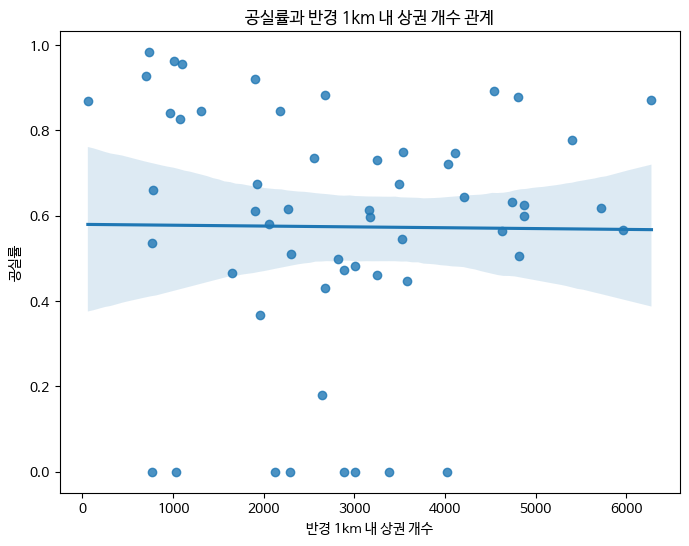

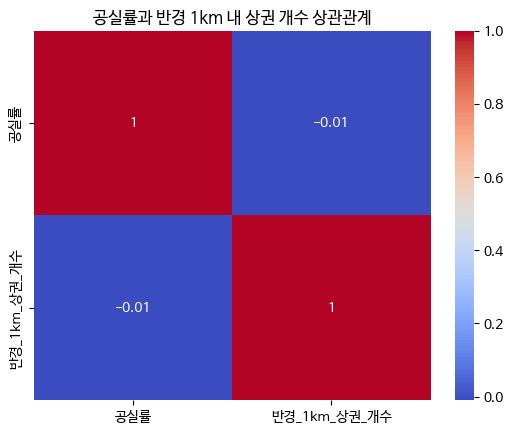

In [88]:
# 상관관계 분석 및 시각화
plt.figure(figsize=(8, 6))
sns.regplot(x=df_center_commerce['반경_1km_상권_개수'], y=df_center_commerce['공실률'])
plt.title("공실률과 반경 1km 내 상권 개수 관계")
plt.xlabel("반경 1km 내 상권 개수")
plt.ylabel("공실률")
plt.show()

correlation_2 = df_center_commerce[['공실률', '반경_1km_상권_개수']].corr()
sns.heatmap(correlation_2, annot=True, cmap="coolwarm")
plt.title("공실률과 반경 1km 내 상권 개수 상관관계")
plt.show()

In [89]:
# 머신러닝 모델 학습
X = df_center_commerce[['반경_1km_상권_개수']].dropna()
y = df_center_commerce.loc[X.index, '공실률']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("Linear Regression R² Score (반경 1km 내 상권 개수):", r2_score(y_test, y_pred_lr))

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest R² Score (반경 1km 내 상권 개수):", r2_score(y_test, y_pred_rf))

Linear Regression R² Score (반경 1km 내 상권 개수): -0.05304895718656244
Random Forest R² Score (반경 1km 내 상권 개수): -1.5621812152634744


# **가설 3: 개별공시지가에 따른 공실률 분석**

In [96]:
# 법정동 코드 및 PNU 추가 (표제부 데이터 활용)
df_building = data["표제부"].copy()
df_building = df_building[['bld_nm', 'PNU']].rename(columns={'bld_nm': '센터명'})
df_building['PNU'] = df_building['PNU'].astype(str).str.zfill(19)
df_center = df_center.merge(df_building, on="센터명", how="left")

In [101]:
# 개별공시지가 데이터 결합 (PNU 활용)
df_land_price = data["개별공시지가"].copy()
df_land_price = df_land_price[['PNU', 'land_value']].rename(columns={'land_value': '개별공시지가'})
df_land_price['PNU'] = df_land_price['PNU'].astype(str).str.zfill(19)
df_center = df_center.merge(df_land_price, on="PNU", how="left")

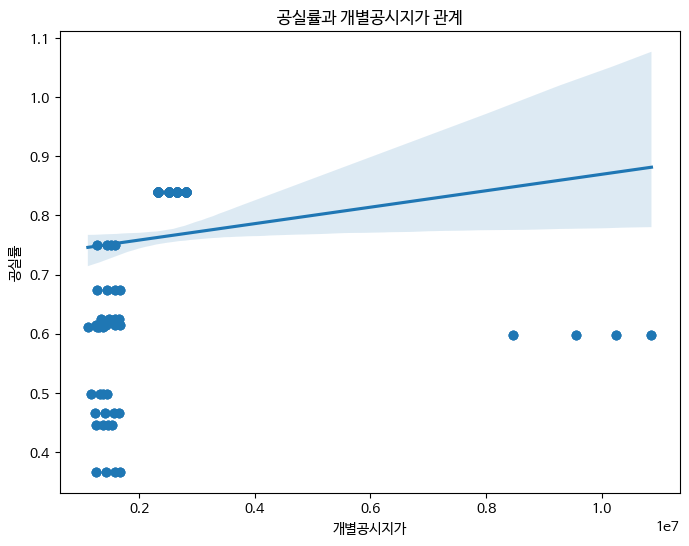

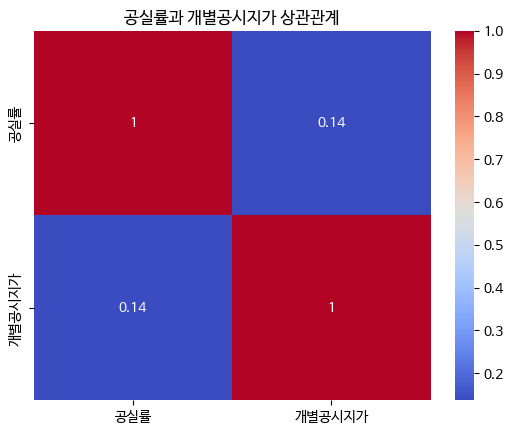

In [102]:
# 상관관계 분석 및 시각화
plt.figure(figsize=(8, 6))
sns.regplot(x=df_center['개별공시지가'], y=df_center['공실률'])
plt.title("공실률과 개별공시지가 관계")
plt.xlabel("개별공시지가")
plt.ylabel("공실률")
plt.show()

correlation_3 = df_center[['공실률', '개별공시지가']].corr()
sns.heatmap(correlation_3, annot=True, cmap="coolwarm")
plt.title("공실률과 개별공시지가 상관관계")
plt.show()

In [103]:
# 머신러닝 모델 학습
X = df_center[['개별공시지가']].dropna()
y = df_center.loc[X.index, '공실률']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("Linear Regression R² Score (개별공시지가):", r2_score(y_test, y_pred_lr))

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest R² Score (개별공시지가):", r2_score(y_test, y_pred_rf))

Linear Regression R² Score (개별공시지가): 0.0034665852402401276
Random Forest R² Score (개별공시지가): 0.8647682662704119
